Outlier Detection
=====

### What is an outlier?

An outlier is an observation or a set of observations exceptionally far from the mainstream of data. It's either:
1. an extreme case (Anomaly)
2. an error eg typo, measuring error, etc (Noise)

Typically, Analysts/Data Scientist are more interested in (1) Unless we just wanted cleanout Noise, which is also a common use case.

### What to do with outliers?
Depends on the business focus but here are some general routes:

1. remove outliers to strengthen our model and/or insights 
2. study them for insight e.g. fix a measuring error, motivate changes to the model, blog post of a special case, etc.
3. fraud detection

The techniques used for this dataset are as follows--
- Extreme value analysis
- Information theory: PCA    
- Dependency variable error


__bottom line:__ finding outliers/anomalies often depends on the business interest. e.g. building a strong model where outliers just amount to a hinderance in performance vs. studying anomalous cases for insight.

### next steps:
- Clustering in this order:
    1. Tsne to see how well the data clusters i.e. are they disparate data points or do they cluster well.
    2. GMM
    3. DBSCAN



In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

from helpers import plot_no_transformation, plot_optimal_number_of_components_variance
from helpers import score_classifier

import matplotlib.pyplot as plt
%pylab inline
plt.style.use('fivethirtyeight')


import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [5]:
df_ratings_sample = pd.read_csv('ratings_sample.tsv', sep='\t')

# Extreme value analysis

__Boxplot --__
Theoritically, anything above the top whisker (aprox 43) is an outlier given the distribution is gaussian-like. Though notice a very extreme case: 112 years old and nothing in between - seems suspicious.

_This exercise should be repeated for all features though in interest of time, I've limited it to just this one_

count    500763.000000
mean         28.965531
std           5.164825
min          18.000000
25%          25.000000
50%          28.000000
75%          32.000000
max         112.000000
dtype: float64
skew --  1.2225473630024877
kurtosis-- 3.7030868774085564


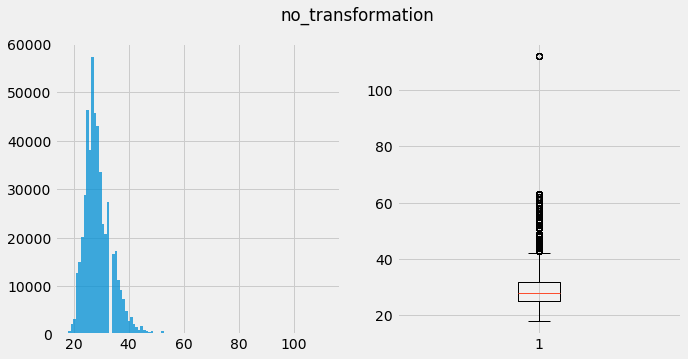

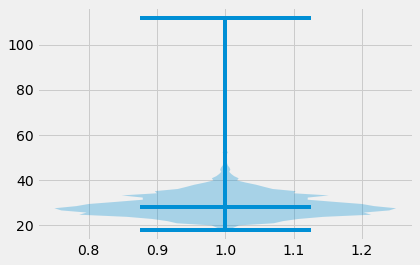

In [6]:
plot_no_transformation(list(df_ratings_sample.player_age))

In [7]:
df_player_age_outliers = df_ratings_sample[df_ratings_sample.player_age == 112]
df_player_age_outliers

,like,player_id,subject_id,player_age,player_height,player_age_max,player_age_min,player_distance_max,player_height_min,player_height_max,...,player_location,subject_gender_orientation,subject_hometown,subject_metro,subject_location,distance,player_saved,player_rated,subject_saved,subject_rated
454904,0.0,01fc7aa7222451673b2804c97b0034ec0681f105,212adeb131102c365e07a7cca958895bfb3995a1,112,170,60,42,100,92,214,...,Regal_Heights,MS,Ottawa_Ontario,Toronto,Greektown,4.226219,0,0,0,107
454905,0.0,01fc7aa7222451673b2804c97b0034ec0681f105,96178849994686461c71eded66b22a4b0bf962b5,112,170,60,42,100,92,214,...,Regal_Heights,MS,Cornwall_Ontario,Other,Clairfields,39.918329,0,0,1,82
454906,0.0,01fc7aa7222451673b2804c97b0034ec0681f105,b15a265754b182df8ed2cd58d12c8c8e4c6cb2ce,112,170,60,42,100,92,214,...,Regal_Heights,MS,Colden_New_York,Buffalo,Chaffee,91.142046,0,0,0,54
454907,0.0,01fc7aa7222451673b2804c97b0034ec0681f105,6c17aec12b7c408ee8e708f220261becaa3ab728,112,170,60,42,100,92,214,...,Regal_Heights,MS,Buffalo_New_York,Washington_D.C.,Annandale,352.332185,0,0,2,77
454908,0.0,01fc7aa7222451673b2804c97b0034ec0681f105,73f153aad08fce26424ce0b04a80562a98af4057,112,170,60,42,100,92,214,...,Regal_Heights,MS,Hamilton_Ontario,Toronto,Thornhill,8.720684,0,0,5,190
454909,0.0,01fc7aa7222451673b2804c97b0034ec0681f105,33796aafc7f99f324442486c4b285a4f9bff6767,112,170,60,42,100,92,214,...,Regal_Heights,MS,Thornhill_Ontario,Toronto,Bracondale_Hill,0.309304,0,0,2,167
454910,0.0,01fc7aa7222451673b2804c97b0034ec0681f105,f407df1c89f7b1df1a330225eab42f5b1ecf851a,112,170,60,42,100,92,214,...,Regal_Heights,MS,Toronto_Ontario,Toronto,Pleasant_View,8.825765,0,0,11,105


## Duplicate profiles

Examining only the player attributes, it's just a single person. At first blush, it seemed as if this was a fraudulent case considering the distances from the subject however it could very well be a 112 year old woman seeking a (younger) companion.

In [8]:
player_only_features = [name for name in df_ratings_sample.columns if 'player' in name]
df_player_age_outliers[player_only_features].drop_duplicates().T

,454904
player_id,01fc7aa7222451673b2804c97b0034ec0681f105
player_age,112
player_height,170
player_age_max,60
player_age_min,42
player_distance_max,100
player_height_min,92
player_height_max,214
player_gender_orientation,FS
player_hometown,Toronto_Ontario


She seems to find interest in males from 42-60. it's interesting she has an age_max cap of 60. Begs the question why?

In [9]:
df_player_age_outliers.subject_age

454904    42
454905    45
454906    44
454907    42
454908    43
454909    44
454910    48
Name: subject_age, dtype: int64

## Distances from subject

Given the sparsity of users within this age range, it seems you'd have to travel a larger distance to find a match.

72.21064742857142

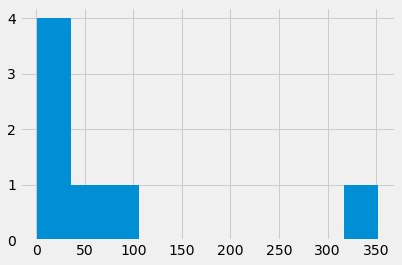

In [10]:
df_player_age_outliers.distance.hist()
df_player_age_outliers.distance.mean()

# Information theory: PCA

How compressable is the data? Another technique used to tell whether or not a dataset has outliers is to check how much redundant information it has. By theory, if it has a lot redundant information - there aren't many outliers - it'll compress well. 

In this example, we'll use PCA..



number of components that explain target amt of variance explained: 16 @ 0.961780412622


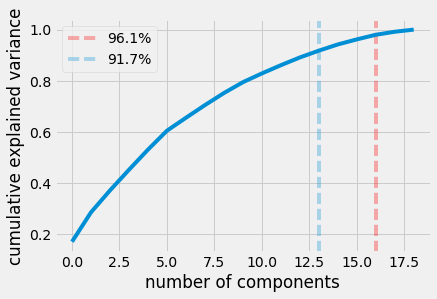

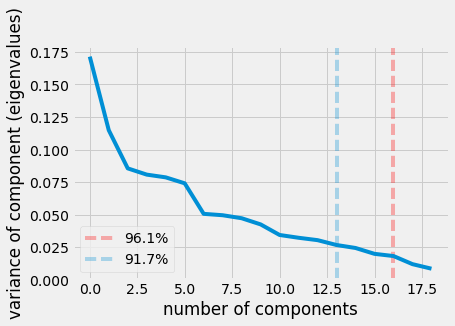

16

In [11]:

features = [
    'player_age',
    'player_height',
    'player_age_max',
    'player_age_min',
    'player_distance_max',
    'player_height_min',
    'player_height_max',
    'subject_age',
    'subject_height',
    'subject_age_max',
    'subject_age_min',
    'subject_distance_max',
    'subject_height_min',
    'subject_height_max',
    'distance',
    'player_saved',
    'player_rated',
    'subject_saved',
    'subject_rated',
]


scaler = StandardScaler()
scale_feature_collinear_feature_M = scaler.fit_transform(df_ratings_sample[features])

THRESHOLD_FOR_VARIANCE_RETENTION = 0.95
plot_optimal_number_of_components_variance(scale_feature_collinear_feature_M, THRESHOLD_FOR_VARIANCE_RETENTION)

## Finding the number of components to retain

Given that there are 19 total features and in order to retain 95% of the variance we can only lose 3 components, we can conclude the dataset is fairly disperse. It doesn't mean it necessarily has a lot of outliers but it means there isn't a lot of redundancy in the data.

We can see this examining the scree plot just above. In a dataset that's highly compressable we would see a stark hockey stick like drop making a sharp angle (an elbow). It's at this point it's yields the optimal number of components to retain.

Another method to figure out the number of components to retain is Kaiser's rule. It finds the point at which each additional components contribution to information (variance) is marginal. It's 91.7% indicated by the blue line.

Potential next steps--

1. Retain full number of components post transformation then find the centroid/medoid and compute distances of all examples from the centroid and score the furthest ones as outliers.
2. Extreme Value Analysis - just like above - on each of the components and remove outliers.
3. Using a wrapper function, find the optimal number of components to retain by model performance. That is, grid-search the number of components to retain. This method assumes our main concern is model performance and not intrepretation of causality from features.

Pros: quick and dirty implementation possible with minimal analysis
Cons: Loss of intrepretation of features say if you wanted to study outliers.

__*Note, PCA is a function of features as opposed to examples/observations. Meaning it might better at pruning outliers from a feature's perspective vs distance from other examples.__

# Dependency variable error

This method involves fitting a model to the dataset and computing the prediction errors of all the examples originally trained on and inspecting the cases with the highest errors. Assuming the model's reliable, these cases of uncertaintly could be interesting for a variety of reasons at the minimum providing insight as to where the model's weak.


In [12]:


labels = df_ratings_sample.like == 1.0
X = df_ratings_sample[features]

rf = RandomForestClassifier(
    n_jobs=-1, 
    class_weight='balanced_subsample', 
    random_state=40).fit(X, labels)

mean_roc_auc_score = score_classifier(rf, X, labels)[0]
mean_roc_auc_score, sum(labels)/len(labels)

(0.83261574188601062, 0.17553014100482664)

With Mean Roc AUC of 83 we can say the model's fairly discriminative (reliable). That is, the model's correct 83% of the time it makes a prediction. Though we have a class imbalance issue with likes only comprising 17.5% of the data.


### How's the class imbalance addressed?
- For purposes of speed, I'm adjusting the classweights to penalize missclassifications for the minority to be higher.
- stratified bootstrap sampling for training trees.
- stratified sampling without replacement for 5-fold cross validation.


### Why is Random forest a good base model for this technique?
- It handles outliers well, that is it maintains the attributes of tree based models which make it robust in discrimination while also being robust to outliers by design: An independent ensemble of Trees. This is superior to a sequential ensemble (Boosting) which is famed for best classifiers to date.
- interpretability (see below)


0.0    0.576928
0.1    0.167886
0.2    0.055352
0.3    0.018528
0.4    0.008333
0.5    0.010290
0.6    0.020153
0.7    0.034384
0.8    0.043699
0.9    0.040991
1.0    0.023456
dtype: float64

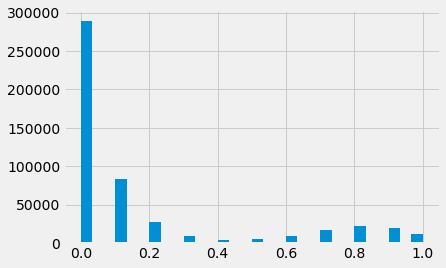

In [13]:
scores = rf.predict_proba(X)
probability_of_true = pd.Series(scores[:,1])
probability_of_true.hist(bins=30)
probability_of_true.value_counts(1).sort_index()

We can see at 0.4 only 0.8% of examples fall into this area. This makes for a good starting point. Though the reality is we'd want to investigate everything from 0.4-0.6: 
1. classifier is on the fence with a decision
2. it comprises a minority group

A good starting point of investigation of such features is to use the feature importance plot showed in the previous analysis and figure out how/why the datapoints differ from the rest in the most important categories the model uses for it's prediction.

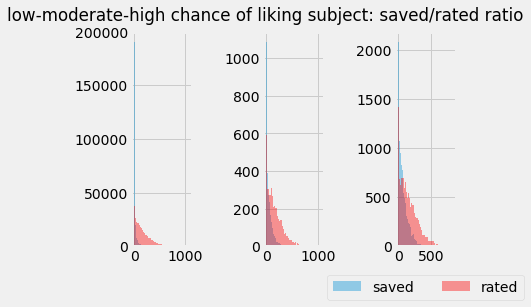

In [14]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3)

cohort_idx = probability_of_true[probability_of_true == 0.0].index
df_certain_false = X.ix[cohort_idx]
df_certain_false.subject_saved.hist(bins=50, alpha=0.4, ax=ax1)
df_certain_false.subject_rated.hist(bins=50, alpha=0.4, color='red', ax=ax1)


cohort_idx = probability_of_true[probability_of_true == 0.4].index
df_uncertain = X.ix[cohort_idx]
df_uncertain.subject_saved.hist(bins=50, alpha=0.4, ax=ax2)
df_uncertain.subject_rated.hist(bins=50, alpha=0.4, color='red', ax=ax2)


cohort_idx = probability_of_true[probability_of_true == 1.0].index
df_certain_false = X.ix[cohort_idx]
df_certain_false.subject_saved.hist(bins=50, alpha=0.4, ax=ax3, label='saved')
df_certain_false.subject_rated.hist(bins=50, alpha=0.4, color='red', ax=ax3, label='rated')
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.1), ncol=2)
plt.suptitle('low-moderate-high chance of liking subject: saved/rated ratio')
plt.tight_layout(pad=1.8)


### Saved to Rated ratio

The amount of the space the blue occupies vs red indicates subjects with a higher ratio tend have a higher chance of being liked. Not suprising but it's always nice to have supportive evidence of data.

It also warns us of releasing a model trained on such patterns and consequences for those unpopular individuals. The same people will be recommended over and over - this isn't good policy for various reasons. To combat this a couple solutions come to mind: 
1. remove the feature altogether or down-weight the importance.
2. ensemble models and limit the recommendations from this model. 
3. select a few subjects completely at random for a few slots in the recommendation.



-0.9         1
-0.8         5
-0.7        24
-0.6       113
-0.5       609
-0.4      2603
-0.3      8889
-0.2     27651
-0.1     84065
 0.0    300650
 0.1     20526
 0.2     21878
 0.3     17194
 0.4      9979
 0.5      4544
 0.6      1570
 0.7       389
 0.8        67
 0.9         6
Name: like, dtype: int64

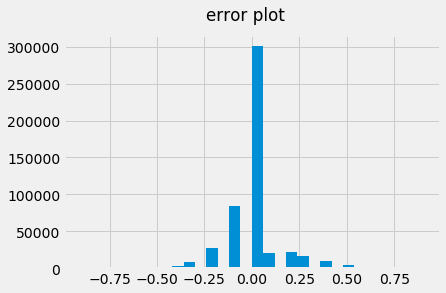

In [15]:
errors = pd.Series(labels.astype(float) - scores[:,1])
errors.hist(bins=30)


plt.suptitle('error plot')
errors.value_counts().sort_index()

This is an interesting case because the model was fairly certian this would be a "like" based on the pattern it's learned but that's clearly not the case.

It's not clear as why this player didn't like this particular subject however, it does seem like the subject's new to the platform given she's only been rated 13 times. Maybe the model doesn't do well with new players on the platform. At a time_been_on_platform may solve this issue.

In [16]:
anomaly_idx = errors[errors == -0.9].index
print (probability_of_true[anomaly_idx])
df_ratings_sample.ix[anomaly_idx].T

40734    0.9
dtype: float64


,40734
like,0
player_id,f9d0c627287ed0f52fbf2c09fdc336c73931da3c
subject_id,e43761fd1f10b6fba0e804b9de9e8e494e03a7e1
player_age,34
player_height,185
player_age_max,33
player_age_min,28
player_distance_max,100
player_height_min,92
player_height_max,214


## Extensions of this technique:

- __Voting committee__: using an ensemble of various other models trained on the same dataset, identify the examples which have the highest disagreeability among the classifiers.


- __Attribute-wise Learning for Scoring Outliers (ALSO)__: Repeating this exercise, iterating through all variables as dependent. From learning weights to identify features which are most relevant. In addition, an analyst could supply an arbitrary weighting scheme.


- __Insight__: given the binary nature of this problem, an analyst could easily figure out the causal factors relating likes such as the ratio up above but also point out rare cases which are exempt from main/trivial set of deciding factors. This is done by interpreting the decision path from the trained trees.
